In [126]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

## Первые строки таблиц и значение атрибутов

In [2]:
lectures = pd.read_csv("data/lectures.csv")
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


* lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
* tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
* part: top level category code for the lecture.
* type_of: brief description of the core purpose of the lecture.

In [110]:
questions = pd.read_csv("data/questions.csv")
questions.head(10)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
5,5,5,2,1,131 149 162 81
6,6,6,2,1,10 94 162 92
7,7,7,0,1,61 110 162 29
8,8,8,3,1,131 13 162 92
9,9,9,3,1,10 164 81


* question_id: foreign key for the train/test content_id column, when the content type is question (0).
* bundle_id: code for which questions are served together.
* correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
* part: the relevant section of the TOEIC test.
* tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [4]:
train = pd.read_csv("data/train.csv",
                    index_col = "row_id",
                    nrows = 1000)
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


* row_id: (int64) ID code for the row.
* timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
* user_id: (int32) ID code for the user.
* content_id: (int16) ID code for the user interaction
* content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
* task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
* user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
* answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
* prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
* prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

## Таблица train огромна. Посчитаем кол-во строк в ней

In [5]:
n_rows = 0

with pd.read_csv("data/train.csv", index_col = "row_id", chunksize = 1000) as reader:
    for chunk in reader:
        n_rows+=len(chunk)
        
print(f"Таблица train содержит {n_rows:,} строк")

Таблица train содержит 101,230,332 строк


Так как строк очень много, ноутбук не справляется с таким объёмом данных. Придётся собирать статистику так же по кусочкам.
* Кол-во правильных и неправильных ответов по пользователям
* По вопросам (question_id, bundle_id, part) - соотношение между правильными и не правильными ответами. Очень сложные вопросы.
* task_container_id - сложные и не очень
* Подсказка на предыдущем вопросе
* По тегам соотношение правильных и неправильных
* Время на предыдущий вопрос
* Есть ли улучшение с ростом timestamp?
* Влияние посещения лекций

## Для каждого пользователя посчитаем долю правильных ответов

In [7]:
answer_counts = pd.DataFrame()
with pd.read_csv("data/train.csv", index_col = "row_id", chunksize = 10000) as reader:
    for chunk in reader:
        df = chunk[chunk['content_type_id']==0]\
            .groupby('user_id').agg(right_answers=("answered_correctly","sum"),
                                    total_answers=("answered_correctly","count"))
        answer_counts = pd.concat([answer_counts, df], axis=0)
# Повторно группируем и суммируем по пользователю, так как отдельные пользователи могли попасть в разные чанки        
answer_counts = answer_counts.groupby('user_id').agg(right_answers=("right_answers","sum"),
                                     total_answers=("total_answers","sum"))

In [8]:
answer_counts["right_answers_%"] = answer_counts["right_answers"]/answer_counts["total_answers"]

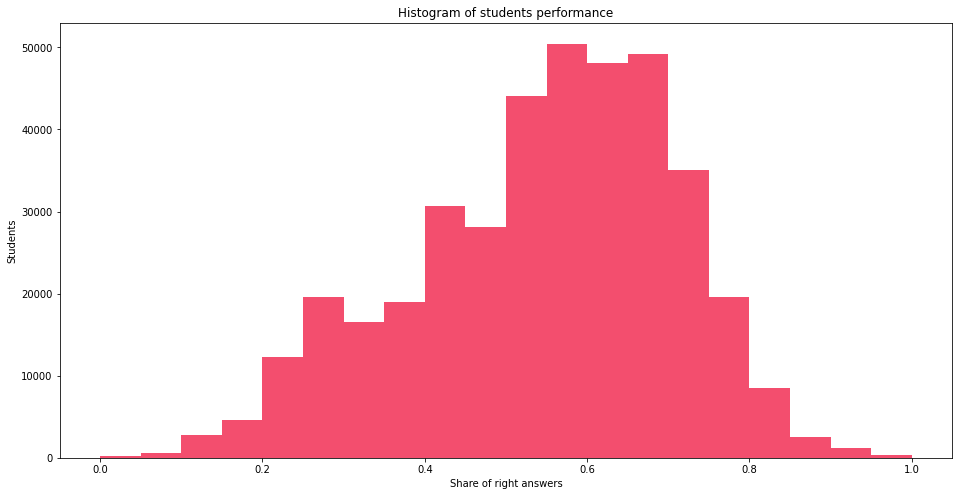

In [108]:
plt.subplots(figsize=(16, 8))
plt.xlabel("Share of right answers")
plt.ylabel("Students")
plt.title("Histogram of students performance")
plt.hist(answer_counts["right_answers_%"], bins = 20, color = "#f34e6e")
plt.show()

Основная масса студентов (середнячки) отвечает правильно на 50 - 80 % теста. Отличников (больше 80%) не так много.

## Посмотрим долю правильных ответов по question_id, bundle_id, part и task_container_id. Может быть есть аномально сложные или очень простые вопросы/группы вопросов

In [161]:
q_answer_counts = pd.DataFrame()
with pd.read_csv("data/train.csv", index_col = "row_id", chunksize = 100000) as reader:
    for chunk in reader:
        df = chunk[chunk["content_type_id"]==0]\
                .groupby(["content_id", "task_container_id"])\
                         .agg(right_answers=("answered_correctly","sum")
                              ,total_answers=("answered_correctly","count"))
        q_answer_counts = pd.concat([q_answer_counts, df], axis=0
                                    
# Повторно группируем и суммируем по пользователю, так как отдельные пользователи могли попасть в разные чанки        
q_answer_counts = q_answer_counts.groupby(["content_id", "task_container_id"]).agg(right_answers=("right_answers","sum"),
                                     total_answers=("total_answers","sum"))

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [98]:
q_answer_counts.reset_index(inplace = True)
q_answer_counts.rename(columns = {'content_id': 'question_id'}, inplace = True)
q_answer_counts = q_answer_counts.merge(questions,
                                      how='left',
                                      on='question_id')
q_answer_counts.head()

,question_id,right_answers,total_answers,right_answers_%,bundle_id,correct_answer,part,tags
0,0,6266,6903,0.907721,0,0,1,51 131 162 38
1,1,6589,7398,0.890646,1,1,1,131 36 81
2,2,24890,44905,0.554281,2,0,1,131 101 162 92
3,3,17906,22973,0.779437,3,0,1,131 149 162 29
4,4,19461,31736,0.613215,4,3,1,131 5 162 38


In [123]:
part_answer_counts = q_answer_counts.groupby("part").agg(right_answers=("right_answers","sum"),
                                     total_answers=("total_answers","sum"))
part_answer_counts["right_answers_%"] = part_answer_counts["right_answers"]/part_answer_counts["total_answers"]
with pd.option_context('display.float_format', '{:,.2%}'.format):
    print(part_answer_counts[['right_answers_%']].sort_values(by = 'right_answers_%'))

      right_answers_%
part                 
5              61.01%
4              63.10%
7              65.96%
6              66.94%
3              70.15%
2              70.87%
1              74.50%


Судя по данным, получается, что часть 1 даётся студентам проще всего, а часть 5 - сложнее всего.
Разные части теста ожидаемо имеют разный уровень сложности. Какие тут могут быть причины:
* Каждая часть теста состоит из ряда однотипных вопросов. Характер вопросов при этом отличается (что-то студентам дайтся проще, что-то сложнее). Например, в первых четырёх частях нужно воспринимать информацию на слух, в последних трёх - работа с текстом.
* В первой части (лучший средний балл) студент отвечает всего на 6 вопросов (данные с сайта о тесте), а в пятой (худший средний балл) - 30 (студенту может быть сложнее концентрироваться так долго).
* Кроме того, на первой части (в начале тестирования) голова ещё "свеженькая" и хорошо соображает, к концу теста мозг может уставать и больше ошибаться.


https://www.iibc-global.org/english/toeic/test/lr/about/format.html

Далее визуализируем, насколько успешно студенты отвечают на вопросы в разных частях теста.

In [124]:
part_q_answer_counts = q_answer_counts.groupby(["part", "question_id"])\
                                      .agg(right_answers=("right_answers","sum"),
                                           total_answers=("total_answers","sum"))
part_q_answer_counts["right_answers_%"] = part_q_answer_counts["right_answers"]/part_q_answer_counts["total_answers"]
part_q_answer_counts.reset_index(inplace = True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


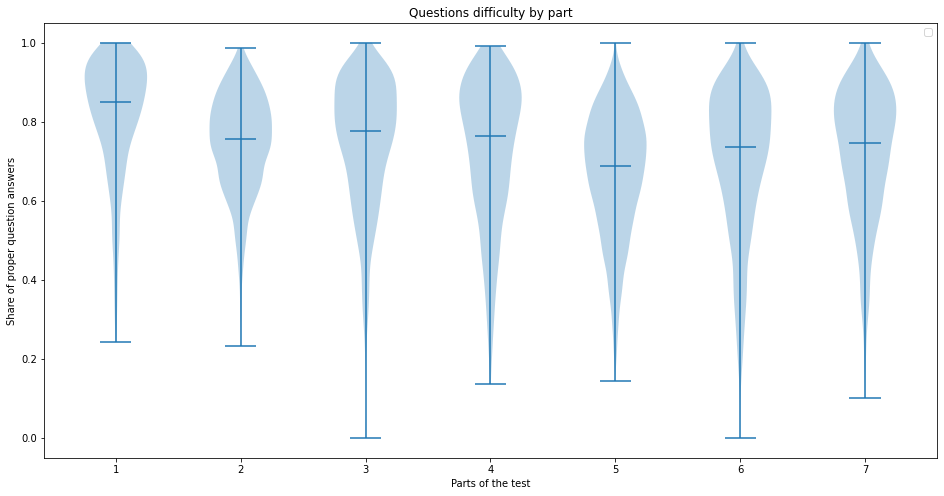

In [142]:
fig, ax = plt.subplots(figsize=(16, 8))
x = list(part_q_answer_counts['part'])
y = [list(part_q_answer_counts[part_q_answer_counts.part==i]['right_answers_%']) for i in range(1,8)]
ax.violinplot(y,
                  showmeans=False,
                  showmedians=True)
ax.set_title('Questions difficulty by part')
ax.set_xlabel("Parts of the test")
ax.set_ylabel("Share of proper question answers")
ax.legend()
plt.show()

Здесь тоже видно, что разные части теста по-разному даются студентам:
* В 3 и 6 группах есть вопросы, на которые никто не смог ответить
* Лучше всего студенты справляются с первой частью.

Посмотрим, что это за вопросы, на которые никто не ответил

In [149]:
part_q_answer_counts[part_q_answer_counts['right_answers_%']==0]

,part,question_id,right_answers,total_answers,right_answers_%
2723,3,1484,0,1,0.0
2724,3,1485,0,1,0.0
2725,3,1486,0,1,0.0
11560,6,10007,0,1,0.0


По этим вопросам было собрано всего одно наблюдение! По таким единичным наблюдениям нельзя судить о степени сложности вопроса, поэтому далее исключим их из выборки.
Какое количество накопленных ответов считать достаточным? Посмотрим, что нам скажет метод describe.

In [154]:
part_q_answer_counts["total_answers"].describe(percentiles=[.05, .1, .15,.25, .5, .75])

count     13523.000000
mean       7340.922872
std       11455.927774
min           1.000000
5%          153.000000
10%         283.000000
15%         913.000000
25%        1765.500000
50%        4732.000000
75%        8556.000000
max      213605.000000
Name: total_answers, dtype: float64

Чтобы не удалять слшком много вопросов, попробуем оставить только те вопросы, на которые было дано от 150 ответов (отрежем ~5% самых непопулярных вопросов). И посмотрим, как измениться график.

In [155]:
part_q_answer_counts = part_q_answer_counts[part_q_answer_counts["total_answers"]>=150]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


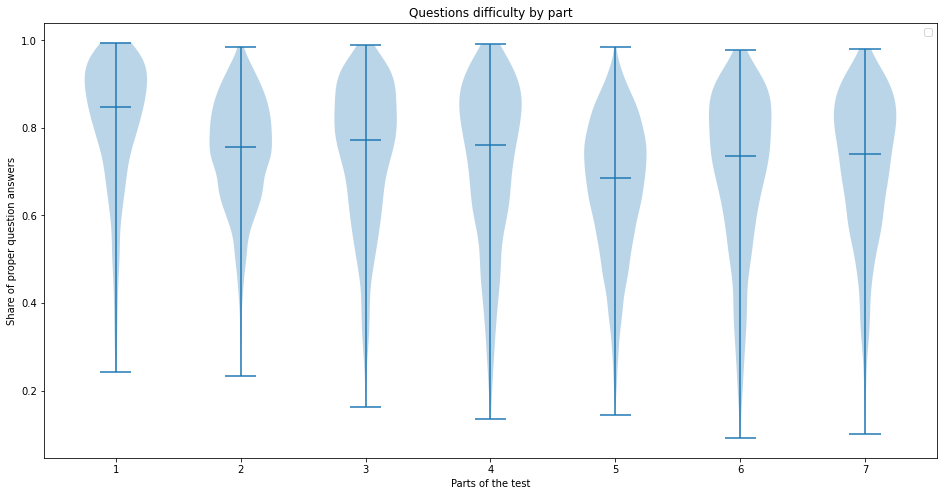

In [156]:
fig, ax = plt.subplots(figsize=(16, 8))
x = list(part_q_answer_counts['part'])
y = [list(part_q_answer_counts[part_q_answer_counts.part==i]['right_answers_%']) for i in range(1,8)]
ax.violinplot(y,
                  showmeans=False,
                  showmedians=True)
ax.set_title('Questions difficulty by part')
ax.set_xlabel("Parts of the test")
ax.set_ylabel("Share of proper question answers")
ax.legend()
plt.show()

Картинка существенно не изменилась. Первая часть по-прежнему определяется как самая простая, пятая - как самая сложная. Остальные части примерно на одном уровне сложности.
Для прогнозирования вероятности правильного ответа можно попробовать использовать фичу части теста одним их двух вариантов и выбрать тот, с которым получается лучший результат:
* вариант А - каждой части теста соответствует своя категория
* вариант Б - поделить части на 3 категоррии: сложная (часть 5), простая (часть 1) и средние (все остальные)

In [ ]:
x+3

In [6]:
train_lectures = train[train['content_type_id']==1][['timestamp', 'user_id', 'content_id', 'task_container_id']]
train_lectures.rename(columns = {'content_id': 'lecture_id'}, inplace = True)
train_lectures = train_lectures.merge(lectures,
                                      how='left',
                                      on='lecture_id')
train_lectures['type_of'] = train_lectures['type_of'].astype('category')

In [7]:
train_lectures[train_lectures["user_id"]==12741]

,timestamp,user_id,lecture_id,task_container_id,tag,part,type_of
7,3083871588,12741,20307,33,170,6,concept
8,3263276452,12741,10688,53,39,7,concept
9,3268387671,12741,10217,66,19,7,concept
10,3577136075,12741,3852,67,161,4,solving question
11,3777499330,12741,18186,88,161,4,concept
12,4465486358,12741,22792,106,161,4,solving question


In [10]:
train_lectures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   timestamp          18 non-null     int64   
 1   user_id            18 non-null     int64   
 2   lecture_id         18 non-null     int64   
 3   task_container_id  18 non-null     int64   
 4   tag                18 non-null     int64   
 5   part               18 non-null     int64   
 6   type_of            18 non-null     category
dtypes: category(1), int64(6)
memory usage: 1.1 KB


In [32]:
lectures.groupby("part").agg(a=("type_of","sum"),b=("type_of","count"))

,a,b
part,,
1,conceptconceptsolving questionsolving question...,54
2,conceptsolving questionsolving questionconcept...,56
3,solving questionconceptconceptconceptsolving q...,19
4,conceptsolving questionsolving questionconcept...,31
5,conceptsolving questionsolving questionconcept...,143
6,conceptsolving questionconceptconceptsolving q...,83
7,conceptconceptsolving questionconceptconceptco...,32
